# Defunct analysis: looking at relationships between fixed mutations during evolution and the fitness effects of our mutations - This is just very underpowered, but leaving it here
### Belongs one directory up (in terms of paths)

# OK the idea here is to see whether we can detect any genes where non-syn mutations in that gene predict the fitness effect of one of the TnSeq mutations
### Plan:
* many t-tests between mutations and s or residual s
* null model is gene hits shuffled

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import scipy.stats as sci_stats
from collections import defaultdict
colors = sns.color_palette('colorblind')

In [2]:
vtn_s = pd.read_csv('../../output/VTn_s.csv')
vtn_x = pd.read_csv('../../output/VTn_x.csv')
vtn_s['Cond'] = vtn_s['Pop'].str[:2] + '_' + vtn_s['Environment']
vtn_s = vtn_s.merge(vtn_x[['Sample', 'Fitness', 'Freq_T0', 's_VLTE']], on='Sample', how='left')
vtn_s = vtn_s[vtn_s['Cond']!='P1_SC_37C']
vtn_s.head(3)

,Sample,Environment,Gen_pop,Pop,Gen,Edge,s,stderr,num_cbcs,Cond,Fitness,Freq_T0,s_VLTE
263,G5150_P3G06_SC_37C,SC_37C,G5150_P3G06,P3G06,5150,AAAACATTATCAAAG,-0.002876,0.002160,5,P3_SC_37C,0.051411,0.499523,0.045347
264,G5150_P3G06_SC_37C,SC_37C,G5150_P3G06,P3G06,5150,AAAAGAAAAATGTAT,0.000228,0.000796,5,P3_SC_37C,0.051411,0.499523,0.045347
265,G5150_P3G06_SC_37C,SC_37C,G5150_P3G06,P3G06,5150,AAAAGCGACATTTCT,-0.006614,0.002584,4,P3_SC_37C,0.051411,0.499523,0.045347


In [3]:
def get_resid(r):
    if r['Edge'] in linregress_dict[r['Cond']]:
        lr = linregress_dict[r['Cond']][r['Edge']]
        return r['s'] - (r['Fitness']*lr[0]+lr[1])
    else:
        return 0
    
def centered_s(r, cond):
    if cond == 'All':
        return r['s'] - edge_means['All'][r['Edge']]
    elif r['Cond'] == cond:
        return r['s'] - edge_means[cond][r['Edge']]
    else:
        return np.nan

linregress_dict = defaultdict(dict)
edge_means = defaultdict(dict)
edge_stds = defaultdict(dict)
for edge in set(vtn_s['Edge']):
    edge_means['All'][edge] = np.mean(vtn_s[vtn_s['Edge']==edge]['s'])
    edge_stds['All'][edge] = np.std(vtn_s[vtn_s['Edge']==edge]['s'])
    for cond in ['P1_YPD_30C', 'P3_SC_37C']:
        df = vtn_s[vtn_s.Cond==cond]
        td = df[(pd.notnull(df['Fitness'])) & (pd.notnull(df['s'])) & (df['Edge']==edge)]
        edge_means[cond][edge] = np.mean(td['s'])
        edge_stds[cond][edge] = np.std(td['s'])
        if len(td) >= 20:
            linregress_dict[cond][edge] = sci_stats.linregress(td['Fitness'], td['s'])
            

vtn_s['resid_s'] = vtn_s.apply(get_resid, axis=1)
resid_stds = defaultdict(dict)
for edge in set(vtn_s['Edge']):
    resid_stds['All'][edge] = np.std(vtn_s[vtn_s['Edge']==edge]['resid_s'])
    for cond in ['P1_YPD_30C', 'P3_SC_37C']:
        df = vtn_s[vtn_s.Cond==cond]
        td = df[(pd.notnull(df['Fitness'])) & (pd.notnull(df['s'])) & (df['Edge']==edge)]
        resid_stds[cond][edge] = np.std(td['resid_s'])

for cond in ['All', 'P1_YPD_30C', 'P3_SC_37C']:
    vtn_s['s_centered_'+cond] = vtn_s.apply(lambda r: centered_s(r, cond), axis=1)
vtn_s.head(3)

,Sample,Environment,Gen_pop,Pop,Gen,Edge,s,stderr,num_cbcs,Cond,Fitness,Freq_T0,s_VLTE,resid_s,s_centered_All,s_centered_P1_YPD_30C,s_centered_P3_SC_37C
263,G5150_P3G06_SC_37C,SC_37C,G5150_P3G06,P3G06,5150,AAAACATTATCAAAG,-0.002876,0.002160,5,P3_SC_37C,0.051411,0.499523,0.045347,-0.001863,0.000444,NaN,-0.001721
264,G5150_P3G06_SC_37C,SC_37C,G5150_P3G06,P3G06,5150,AAAAGAAAAATGTAT,0.000228,0.000796,5,P3_SC_37C,0.051411,0.499523,0.045347,0.003231,0.000712,NaN,-0.000832
265,G5150_P3G06_SC_37C,SC_37C,G5150_P3G06,P3G06,5150,AAAAGCGACATTTCT,-0.006614,0.002584,4,P3_SC_37C,0.051411,0.499523,0.045347,0.001610,0.006464,NaN,0.008324


In [10]:
# we can reduce this dataset to unique patterns...
# that's the TO DO

unique_recs = defaultdict(list)
vlte_muts = pd.read_csv('../../output/VLTE_gene_hits_relevant.tsv', delimiter='\t').fillna(0).replace(False, 0).replace(True, 1)
vlte_muts = vlte_muts.set_index('Gene_ORF').T.reset_index()
vlte_muts['Gen_pop'] = vlte_muts['index'].apply(lambda i: 'G'+'_'.join(i.split('_')[-2:]))
genes = [i for i in vlte_muts if i not in ['index', 'Gen_pop'] if vlte_muts[i].sum()>2]
for gene in genes:
    rec = ''.join([str(i) for i in vlte_muts[gene]])
    unique_recs[rec].append(gene)
    
# doing some column renaming based on genes with identical recs
renamer = dict()
base_cols = []
for r in unique_recs:
    base_cols.append(unique_recs[r][0])
    renamer[unique_recs[r][0]] = ';'.join(unique_recs[r])

vlte_mu = vlte_muts[['Gen_pop']+base_cols].rename(columns=renamer)

In [12]:
gene_stds = defaultdict(dict)
for cond in ['All', 'P1_YPD_30C', 'P3_SC_37C']:
    if cond == 'All':
        td = vlte_mu
    else:
        td = vlte_mu[vlte_mu['Gen_pop'].apply(lambda g: g.split('_')[-1][:2]==cond[:2])]
    for gene in renamer.values():
        gene_stds[cond][gene] = np.std(td[gene])
        vlte_mu[gene+'_centered_'+cond] = vlte_mu[gene] - np.mean(td[gene])

In [17]:
gu = renamer.values()
all_edges = set(vtn_s.Edge)
gene_cols = list(gu) + [i+'_centered_All' for i in gu] + [i+'_centered_P1_YPD_30C' for i in gu] + [i+'_centered_P3_SC_37C' for i in gu]
cols = ['Edge', 'Gen_pop', 'Cond', 's', 'resid_s', 's_centered_All', 's_centered_P1_YPD_30C', 's_centered_P3_SC_37C']
big_merge = vtn_s[cols].merge(vlte_mu[['Gen_pop']+gene_cols], on='Gen_pop', how='left')

In [18]:
mat = []
for edge in sorted(all_edges):
    ed = big_merge[big_merge['Edge']==edge]
    for cond in ['All', 'P1_YPD_30C', 'P3_SC_37C']:
        if cond != 'All':
            td = ed[ed.Cond==cond]
        else:
            td = ed
        for gene in gu:
            tmp = [edge, gene, cond]
            pearson = np.sum(td['s_centered_'+cond]*td[gene+'_centered_'+cond])/(gene_stds[cond][gene]*edge_stds[cond][edge])
            pearson_resid = np.sum(td['resid_s']*td[gene+'_centered_'+cond])/(gene_stds[cond][gene]*resid_stds[cond][edge])
            num_w_mut = np.sum(td[gene])
            tmp += [pearson, pearson_resid, num_w_mut, len(td)]
            mat.append(tmp)
ttest_res = pd.DataFrame(mat, columns=['Edge', 'Gene', 'Cond', 'R', 'R_resid', 'N_w_mut', 'N'])
ttest_res.head(2)

/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


,Edge,Gene,Cond,R,R_resid,N_w_mut,N
0,AAAACATTATCAAAG,ADE3,All,-0.417934,5.063773,6,69
1,AAAACATTATCAAAG,ADE6,All,12.619652,16.778147,19,69


In [31]:
edge_info = pd.read_csv('../../../TnSeq/TN_FINAL/Analysis/TP_data_by_edge.csv')
edge_short = edge_info[['Edge', 'Gene.Use']].rename(columns={'Gene.Use': 'Gene_Use'})
tplus = ttest_res.merge(edge_short, on='Edge', how='left')
back_to_pops = dict()
pt_list = list(vlte_muts['Gen_pop'])
for r in unique_recs:
    back_to_pops[';'.join(unique_recs[r])] = ';'.join(set([pt_list[i].split('_')[1] for i in range(len(r)) if r[i]=='1']))
tplus['Pops'] = tplus['Gene'].map(back_to_pops)

In [40]:
tplus.sort_values('R_resid').iloc[:40]

,Edge,Gene,Cond,R,R_resid,N_w_mut,N,Gene_Use,Pops
11489,ATATTGAGTAAGTAC,ABF2;BPH1,All,-50.499780,-57.222919,6,69,nearby YLR264C-A,P1D03
44362,GTTAAATCAACAGTT,COX11;FYV10;HAT2;KAP123;LAA1;MIA40;RGR1;SER3;S...,All,-57.596384,-55.857775,4,70,in SLX8,P1C04
11493,ATATTGAGTAAGTAC,ARP5;CHL1;DET1;DHH1;DSF2;FUB1;FUS2;GDS1;HEM12;...,All,-49.481918,-53.642876,4,69,nearby YLR264C-A,P1D03
8914,AGTTTATAAAAAATT,COX11;FYV10;HAT2;KAP123;LAA1;MIA40;RGR1;SER3;S...,All,-49.695952,-51.727411,4,69,nearby CCW12,P1C04
33122,CTTGATCAATCAAAA,DBP5;PPG1,All,-44.524905,-50.256542,6,67,in PPM1,P3G05
36813,GAGTGCTTCAAAGTT,ARP5;CHL1;DET1;DHH1;DSF2;FUB1;FUS2;GDS1;HEM12;...,All,-45.099036,-50.200327,4,70,in RPS14B,P1D03
44357,GTTAAATCAACAGTT,AKR1;EDE1,All,-53.561056,-49.274697,5,70,in SLX8,P1G04;P1C04
8912,AGTTTATAAAAAATT,BCH1;DRS2;FRS2;IDS2;MOT1;OSH3;RTT101;SSN2;TFC7...,All,-47.366222,-49.090674,5,69,nearby CCW12,P1C04
11495,ATATTGAGTAAGTAC,ATG20;DYN1;GLT1;GUF1;HBT1;RPG1,All,-45.668915,-49.011020,3,69,nearby YLR264C-A,P1D03
44363,GTTAAATCAACAGTT,DBP2,All,-47.190618,-48.487918,5,70,in SLX8,P3G02;P1C04


In [46]:
# old way with t-tests:
mat = []
for edge in sorted(all_edges):
    td = big_merge[big_merge['Edge']==edge]
    for gene in gu:
        tno = td[td[gene]==0]
        tyeah = td[td[gene]==1]
        for cond in ['All', 'P1_YPD_30C', 'P3_SC_37C']:
            tmp = [edge, gene, cond]
            if cond != 'All':
                tcn = tno[tno.Cond==cond]
                tcy = tyeah[tyeah.Cond==cond]
            else:
                tcn = tno
                tcy = tyeah
            tmp += [sci_stats.ttest_ind(tcn['s'], tcy['s'])[1], sci_stats.ttest_ind(tcn['resid_s'], tcy['resid_s'])[1], len(tyeah), len(td)]
            mat.append(tmp)
ttest_res2 = pd.DataFrame(mat, columns=['Edge', 'Gene', 'Cond', 'p', 'p_resid', 'N_w_mut', 'N'])
ttest_res2.head(2)

,Edge,Gene,Cond,p,p_resid,N_w_mut,N
0,AAAACATTATCAAAG,ADE3,All,0.958581,0.528574,6,69
1,AAAACATTATCAAAG,ADE3,P1_YPD_30C,0.403752,0.218812,6,69


In [48]:
tplus2 = ttest_res2.merge(edge_short, on='Edge', how='left')
tplus2['Pops'] = tplus2['Gene'].map(back_to_pops)

In [52]:
edge_info[edge_info['Gene.Use']=='nearby YLR264C-A'][['chromosome', 'insertion_edge']]

,chromosome,insertion_edge
75,chr12,673959


In [58]:
bonferroni = 0.05/(len(tplus2)*2)
sig = tplus2[(tplus2.p<bonferroni) | (tplus2.p_resid<bonferroni)]
print(len(tplus2), len(sig))

63300 199


In [62]:
sig.Pops.value_counts()

P1C04                                              15
P1D03                                              14
P3G05;P1C04                                        11
P3G02;P1C04                                        10
P1C05;P3C03;P1D03;P1C04;P1F05;P1B04                 9
P1C04;P1B04                                         9
P3C03;P1D03                                         8
P1C04;P3F03                                         8
P1C05;P1G04;P1D03;P1C04;P1F05;P1B04                 8
P1B04                                               8
P1C04;P3D03                                         6
P3G02                                               6
P1G04;P1C04                                         5
P3F03                                               4
P3C03;P1C04                                         4
P3C03;P1C04;P1B04                                   4
P3F03;P1B04                                         4
P3G05                                               3
P3G02;P1B04                 

In [60]:
sig.Gene_Use.value_counts()

nearby CCW12        38
in SLX8             32
nearby YLR264C-A    19
nearby NUP188       15
in OCA1             15
nearby NCP1         11
in RPS14B           11
in MPC2              6
in GPP1              5
in RPL31B            5
in PPM1              5
in BUL1              4
in PHO4              4
nearby OST4          3
in UBP1              3
in FLC2              3
in KAP123            3
nearby KRI1          2
in RPL35B            2
nearby VMA7          2
in CPR6              2
in SSK1              2
in VAM6              2
in SLX5              2
nearby YOL085W-A     1
in RPL16A            1
in UBP3              1
Name: Gene_Use, dtype: int64

In [64]:
sig.to_csv('../../poking_around/vlte_associations.tsv', sep='\t', index=False)

# OK checked through those, here are the ones that look the mostconvincing to me:

In [87]:
sig_checked = pd.read_csv('../../poking_around/VLTE_associations_checked.txt', delimiter='\t', encoding = "ISO-8859-1")
sig_checked.head(3)

,Gene_Use,Pops,Notes,Show,Main condition,Edge
0,in CPR6,P1B04,"last 3 tps looks more deleterious, could be SN...",True,P1,ATTATCAAGTGCCAG
1,in BUL1,P1B04,more del in P1B04 (early at least),True,P1,CAAGGATCCCCGTAG
2,nearby NUP188,P1B04,not great data,False,P1,CGAACAGAAACACAA


In [69]:
p1_pops = ['P1B04','P1C04','P1C05','P1D03','P1F05','P1G04']
p3_pops = ['P3C03','P3D03','P3F03','P3G02','P3G05','P3G06']
cond_pops = {'P1': p1_pops, 'P3': p3_pops}
color_map = {p1_pops[i]:colors[i] for i in range(len(p1_pops))}
color_map.update({p3_pops[i]:colors[i] for i in range(len(p3_pops))})

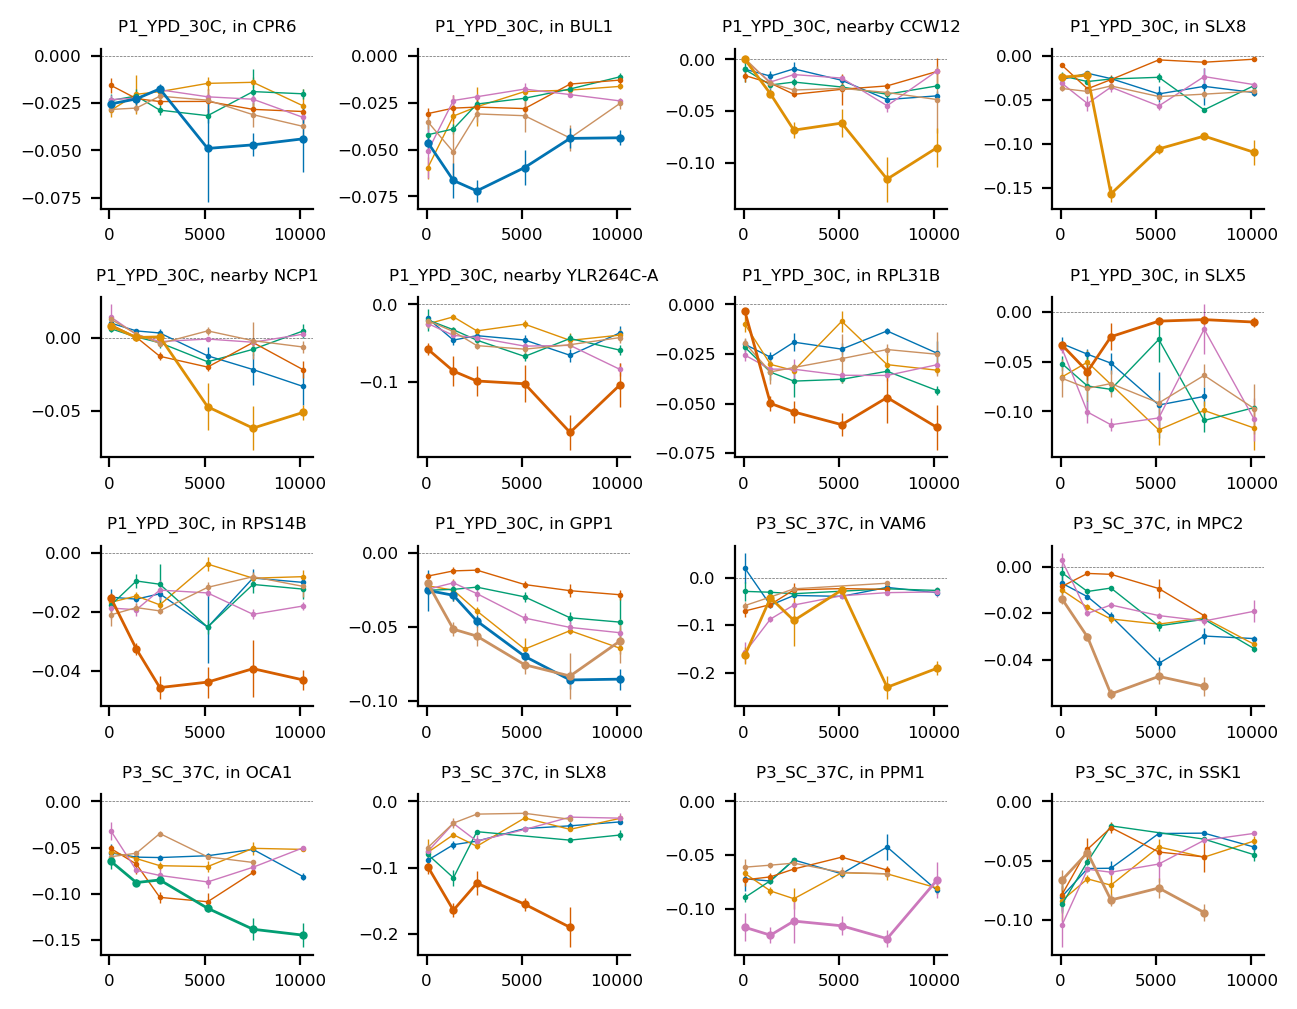

In [90]:
def plot_one(sub, cond, edge, pops_highlight=[], alt_color=None):
    td = vtn_s[(vtn_s['Edge']==edge) & (vtn_s['Cond']==cond)]
    sub.axhline(0, linestyle='dashed', color='k', linewidth=0.25, alpha=0.6)
    for pop in [p for p in cond_pops[cond.split('_')[0]] if p not in pops_highlight]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        sub.errorbar(x=ttd['Gen'], y=ttd['s'], yerr=ttd['stderr'], linestyle='-', marker='.', markersize=2, linewidth=0.5, color=color_map[pop], label=pop)
    for pop in [p for p in cond_pops[cond.split('_')[0]] if p in pops_highlight]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        sub.errorbar(x=ttd['Gen'], y=ttd['s'], yerr=ttd['stderr'], linestyle='-', marker='.', markersize=4, linewidth=1, elinewidth=0.5, color=color_map[pop], label=pop)
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6)

f, subps = pl.subplots(4, 4, figsize=(7.5, 6), dpi=200)
pl.subplots_adjust(hspace=0.55, wspace=0.5)
subs = [subps[i][j] for i in range(4) for j in range(4)]
i = 0
cond_fix = {'P1': 'P1_YPD_30C', 'P3': 'P3_SC_37C'}
for jnk, row in sig_checked[sig_checked.Show].iterrows():
    plot_one(subs[i], cond_fix[row['Main condition']], row['Edge'], pops_highlight=row['Pops'].split(';'))
    subs[i].set_title(cond_fix[row['Main condition']] + ', ' + row['Gene_Use'], fontsize=6)
    i += 1
sns.despine()

In [61]:
tplus2[tplus2.Gene_Use=='in ADE5,7'].sort_values('p')

,Edge,Gene,Cond,p,p_resid,N_w_mut,N,Gene_Use,Pops
6966,AGATTCATCCCATGG,ADE6,All,0.002564,0.003423,19,69,"in ADE5,7",P3G05;P1C05;P1B04;P3C03
6968,AGATTCATCCCATGG,ADE6,P3_SC_37C,0.006662,0.017192,19,69,"in ADE5,7",P3G05;P1C05;P1B04;P3C03
7229,AGATTCATCCCATGG,SIZ1,P3_SC_37C,0.006662,0.017192,14,69,"in ADE5,7",P3G05;P1C05;P1D03;P3C03
7227,AGATTCATCCCATGG,SIZ1,All,0.015168,0.012492,14,69,"in ADE5,7",P3G05;P1C05;P1D03;P3C03
7445,AGATTCATCCCATGG,LCB3,P3_SC_37C,0.015963,0.969914,15,69,"in ADE5,7",P3G05;P3C03;P3G06;P3G02;P3F03
...,...,...,...,...,...,...,...,...,...
7582,AGATTCATCCCATGG,DBP5;PPG1,P1_YPD_30C,NaN,NaN,6,69,"in ADE5,7",P3G05
7585,AGATTCATCCCATGG,YUR1,P1_YPD_30C,NaN,NaN,6,69,"in ADE5,7",P3G05;P3G06
7588,AGATTCATCCCATGG,ADA2;ATP11;DCC1;ECM11;HIS4;LDB19;MCH2;MCM6;MMT...,P1_YPD_30C,NaN,NaN,2,69,"in ADE5,7",P3G06
7591,AGATTCATCCCATGG,ALG7;AQY3;ARG81;CHS2;HSP150;IME4;MET2;NAB3;NVJ...,P1_YPD_30C,NaN,NaN,3,69,"in ADE5,7",P3G06
